In [387]:
import importlib
import utils
from utils import *
importlib.reload(utils)
from utils import *

False


'\nfrom now on, we operate on xtrain_tr_filled -- shape (5117, 7500)\n'

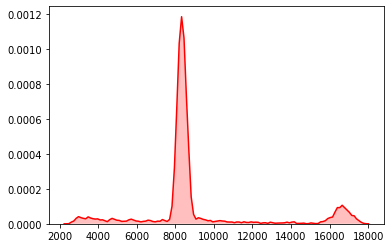

In [23]:
'''
loading data and initial pre-processing
'''

xtrain, xtest, ytrain = load_data()

'''
for each row in xtrain, find indices of last non NaN values
'''
#renaming columns into 0,1,2,...
xtrain = xtrain.rename(columns={x:y for x,y in zip(xtrain.columns,range(0,len(xtrain.columns)))})

'''
last_valid_idx contains the column index for last non-NaN value in the rows of xtrain
'''
last_valid_idx = []

for i in range(0,xtrain.shape[0]):
    row = xtrain.iloc[i,:]
    idx = row.last_valid_index()
    last_valid_idx = np.append(last_valid_idx, idx)
    
'''
plotting kernel density of last_valid_idx
'''
ax = sb.kdeplot(last_valid_idx, shade=True, color="r")

'''
from the kernel density plot, we notice that the majority of series 
starts to show NaN's after the ~7500 index point. We will then first 
attempt classification by truncating all the series at the 7500
column. We will then pad the series which present NaNs before the 7500
columns with the median of the other series. This is just a first trial.
'''

'''
truncate xtrain at 7500 columns -- this prevents us from wasting too much data in truncating
'''
#note to self: load_data() reshiffles the data
xtrain_tr = xtrain.iloc[:,0:7500]


'''
pad shorter series
'''

#consider all rows of xtrain_tr with no NaN's
#Note: we only need to drop all rows with NaN at the last column entry 

#entry i is True if entry is last column in row i of xtrain_tr is NaN 
is_nan = np.isnan(xtrain_tr.iloc[:,-1].values) 
xtrain_tr1 = xtrain_tr[is_nan == False]  #shape = (4565, 7500)
xtrain_tr2 = xtrain_tr[is_nan == True]

#calculate column medians 
medians = np.array(xtrain_tr1.median(axis=0))

for j in xtrain_tr2.columns:
    xtrain_tr2.iloc[:,j] = xtrain_tr2.iloc[:,j].fillna(value = medians[j], axis = 0)
#   print(j)

xtrain_tr_filled = pd.concat([xtrain_tr1, xtrain_tr2])

'''
final dataset: xtrain_tr_filled
dimension: (5117, 7500)
shorter series padded
'''

print(xtrain_tr_filled.isnull().values.any())

'''
from now on, we operate on xtrain_tr_filled -- shape (5117, 7500)
'''

In [394]:
'''
save original in case you screw up
'''

xtrain_tr_filled_orig = xtrain_tr_filled

# Extracting Heartbeats 

In [395]:
import biosppy.signals.ecg as bs_ecg

xtrain_tr_filled = np.array(xtrain_tr_filled)

templates_array = []

for i in range(xtrain_tr_filled.shape[0]):
    beats_info = bs_ecg.ecg(signal= xtrain_tr_filled[i,:], sampling_rate=300, show=False)
    templates_beats = beats_info['templates']
    templates_array.append(templates_beats)

'''
rpeaks_array = []

for i in range(xtrain_hb.shape[0]):
    rpeaks = np.array(bs_ecg.hamilton_segmenter(xtrain_hb[i,:], sampling_rate=300.0))
    rpeaks = rpeaks.flatten()
    rpeaks_array.append(rpeaks)
    
    
rbeats_array = []

for i in range(xtrain_hb.shape[0]):
    rbeats = bs_ecg.extract_heartbeats(signal = xtrain_hb[i,:], 
                rpeaks = rpeaks_array[i], sampling_rate= 300)
    rbeats_array.append(rbeats[0].flatten())

'''

'\nrpeaks_array = []\n\nfor i in range(xtrain_hb.shape[0]):\n    rpeaks = np.array(bs_ecg.hamilton_segmenter(xtrain_hb[i,:], sampling_rate=300.0))\n    rpeaks = rpeaks.flatten()\n    rpeaks_array.append(rpeaks)\n    \n    \nrbeats_array = []\n\nfor i in range(xtrain_hb.shape[0]):\n    rbeats = bs_ecg.extract_heartbeats(signal = xtrain_hb[i,:], \n                rpeaks = rpeaks_array[i], sampling_rate= 300)\n    rbeats_array.append(rbeats[0].flatten())\n\n'

# Extract Summary Statistics 

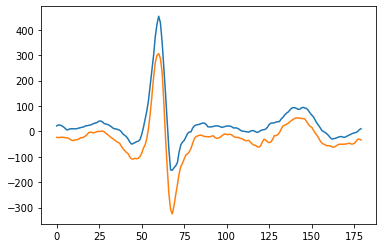

In [406]:
'''
trials
'''

plt.plot(np.max(templates_array[1], axis = 0))
plt.plot(np.min(templates_array[1], axis = 0))
plt.show()

In [401]:
'''
calculating array of medians, maximums and minimums, standard deviations
'''

medians_array = []
max_array = []
min_array = []
std_array = []

for i in range(xtrain_tr_filled.shape[0]):
    maximum = np.max(templates_array[i], axis = 0)
    minimum = np.min(templates_array[i], axis = 0)
    med = np.median(templates_array[i], axis = 0)
    std = np.std(templates_array[i], axis = 0)
    medians_array.append(med)
    max_array.append(maximum)
    min_array.append(minimum)
    std_array.append(std)

In [402]:
'''
create new dataset
'''

biosppy_dat = []
for  i in range(xtrain_tr_filled.shape[0]):
    row_i = np.concatenate([medians_array[1],min_array[1], 
                           max_array[i], std_array[i]])
    biosppy_dat.append(row_i)

biosppy_dat = pd.DataFrame(biosppy_dat)



'''
create train, validation, test splits
xtrain_nn, xval_nn, xtest_nn

'''
xtrain_provisional_hb, xtest_hb, ytrain_provisional_hb, ytest_hb = train_test_split(biosppy_dat, 
                                                          ytrain, test_size=0.2, random_state=42)

xtrain_hb, xval_hb, ytrain_hb, yval_hb = train_test_split(xtrain_provisional_hb,   # test set = val set 
                                                          ytrain_provisional_hb, test_size=0.45, random_state=42)


In [407]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

clf = SVC(C=100.0, kernel='rbf', gamma='auto_deprecated', 
            shrinking=True, probability=False, tol=0.001, cache_size=200, 
            class_weight='balanced', verbose=False, max_iter=-1, 
            decision_function_shape='ovr', random_state=2)

# See whether it is classifying correctly
clf.fit(xtrain_hb, ytrain_hb)
predy = clf.predict(xval_hb)
print(sklearn.metrics.classification_report(yval_hb, predy))

              precision    recall  f1-score   support

           0       0.57      1.00      0.72      1043
           1       0.00      0.00      0.00       156
           2       0.00      0.00      0.00       577
           3       0.00      0.00      0.00        66

    accuracy                           0.57      1842
   macro avg       0.14      0.25      0.18      1842
weighted avg       0.32      0.57      0.41      1842

